In [89]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd

import pickle as pkl
import re
import json
from collections import Counter

import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

import autokeras as ak # !pip install autokeras

from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

# import datetime
# import hvplot

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [90]:
df = pd.read_csv('df_inp.csv')
target = df.pop('target')
target_pred_hui = df.pop('target_pred_hui')
df

,Fs,Fm,Fh,Fb,P_intra,P_inter,Gmag,BPmag,RPmag,Jmag,Hmag,Kmag,W1mag,W2mag,W3mag,Plx,PM,rgeo,b_rgeo,B_rgeo
0,-0.199449,-1.033569,-0.741320,-0.973895,0.697797,NaN,0.492168,0.535112,0.746560,NaN,NaN,NaN,0.853763,0.826402,0.487181,-0.742511,-1.095253,1.198046,1.122459,1.536628
1,1.242478,1.057694,0.753216,0.928074,-1.262540,NaN,0.288212,0.335138,0.531072,1.445468,1.631887,1.702818,0.548266,0.363090,0.268411,-0.514228,-1.089332,0.626017,0.611672,0.782127
2,1.658963,1.776103,1.586837,1.765626,-2.046674,NaN,0.969920,0.969431,1.193379,NaN,NaN,NaN,0.795132,0.706524,0.643446,-0.651198,-2.149547,0.370039,0.200022,0.403904
3,0.534340,0.246240,0.113741,0.121539,-0.290472,NaN,0.722391,0.706965,1.015919,NaN,NaN,NaN,1.180861,1.163357,NaN,-1.107765,-0.699429,0.800462,0.759952,0.929681
4,0.194958,0.751400,1.718708,1.669686,-1.855501,NaN,0.493095,0.407004,0.337767,0.820297,0.852450,0.694386,-0.343539,-0.476057,-0.731684,-0.559884,-0.458692,0.897704,0.625411,0.868525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,-0.158424,0.751400,0.774655,0.635347,0.947295,NaN,0.985371,1.263144,0.819445,0.096013,-0.407573,-0.599130,-0.942189,-0.916690,-0.419154,0.535877,1.124639,-0.078631,-0.521381,0.104488
2937,-1.642453,-0.676575,0.172417,-0.199851,0.947295,NaN,NaN,NaN,NaN,1.838106,1.304766,0.719916,-0.436114,-0.702853,-0.790283,NaN,NaN,NaN,NaN,NaN
2938,-0.010807,0.347246,0.224173,0.067089,0.947295,NaN,-0.176562,0.275771,-0.232641,-0.315685,-0.451997,-0.488500,-0.929846,-0.929650,-1.169225,0.357816,1.145793,-0.862243,-0.774274,-0.921537
2939,0.076830,0.509333,0.350584,0.230456,0.292769,NaN,0.145133,0.816326,0.005029,-0.327121,-0.536806,-0.620405,-1.081052,-1.149966,-1.149692,0.307594,1.262462,-0.782186,-0.755222,-0.788375


In [93]:
SEED = 321 #165 #321 #434

In [95]:
mlb = LabelBinarizer()

y_true = mlb.fit_transform(target)
y_pred_hui = mlb.transform(target_pred_hui)

classes = mlb.classes_

# classes, labels.shape

print(classification_report(y_true, y_pred_hui, 
                            output_dict=False,
                            target_names=classes))

              precision    recall  f1-score   support

         AGN       0.98      0.93      0.95      1390
          CV       0.48      0.55      0.51        44
     HM-STAR       0.67      0.72      0.69       118
        HMXB       0.75      0.69      0.72        26
     LM-STAR       0.81      0.86      0.84       207
        LMXB       0.19      0.26      0.22        65
          NS       0.51      0.68      0.58        87
         YSO       0.93      0.94      0.93      1004

   micro avg       0.89      0.89      0.89      2941
   macro avg       0.67      0.70      0.68      2941
weighted avg       0.90      0.89      0.89      2941
 samples avg       0.89      0.89      0.89      2941



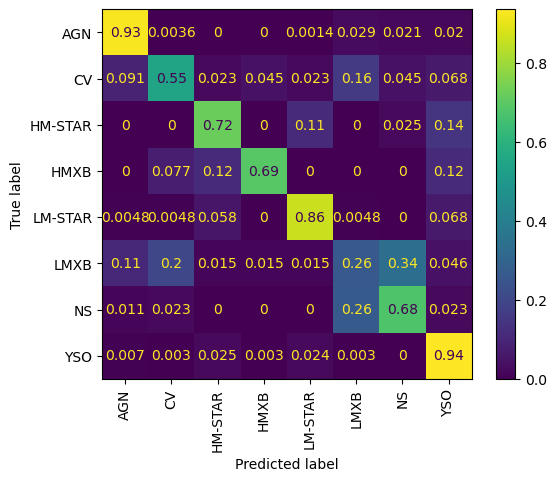

In [117]:
ConfusionMatrixDisplay.from_predictions(
    np.where(y_true==1)[1], 
    np.where(y_pred_hui==1)[1], 
    normalize='true', 
    display_labels=classes,
    xticks_rotation='vertical'
)

In [97]:
# df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)

In [98]:
# keras.metrics.CategoricalAccuracy?

In [99]:
METRICS = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
]

In [100]:
%%time

clf = ak.StructuredDataClassifier(
    overwrite=True, 
    max_trials=1,
    metrics=METRICS,
    # seed=SEED
)


history = clf.fit(
    df,
    y_true,
    epochs=100,
    # callbacks=[tensorboard_callback]
    # verbose=0
)

In [28]:
base_model = clf.export_model()

In [104]:
# use masking nans for RNN such as LSTM!!!
# https://www.tensorflow.org/guide/keras/masking_and_padding

def build_model():

    inputs = keras.layers.Input(shape=(20,))

    x = inputs

    # x = base_model.layers[1](x)
    # x = base_model.layers[2](x)

    x = keras.layers.Normalization()(x)

    x = keras.layers.Dense(32, activation='relu')(x)

    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(32, activation='relu')(x)

    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(32, activation='relu')(x)

    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(8, activation='softmax')(x)

    model = keras.Model(inputs, x)
    
    return model

In [106]:
%%time

mdl = build_model()
        
mdl.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=METRICS)

hist = mdl.fit(
    df.fillna(0), 
    y_true,
    epochs=100, 
    batch_size=32, 
    verbose=0,
    validation_split=0.2
)

CPU times: user 19 s, sys: 1.1 s, total: 20.1 s
Wall time: 14.7 s


In [112]:
n_splits = 5
n_repeats = 1

rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=SEED)

spl = rskf.split(df, target)

out = np.zeros_like(y_true).astype(float)

In [113]:
%%time

for r in range(n_repeats):
        
    for s in range(n_splits):
        
        train_index, test_index = next(spl)
        
        mdl = build_model()
        
        mdl.compile(
            optimizer='adam', 
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
            metrics=METRICS
        )
        
        hist = mdl.fit(
            df.fillna(0).iloc[train_index], 
            y_true[train_index],
            epochs=100, 
            batch_size=32, 
            # validation_data=(padded_docs_test, y_test),
            verbose=0,
            validation_split=0.2
        )
        
        y_p = mdl.predict(df.fillna(0).iloc[test_index])
        
        out[test_index] += y_p
            
    print(r) 
    out_bin = np.floor((out.T/out.max(1)).T).astype(int)  
    
    print(classification_report(
            y_true, 
            out_bin, 
            output_dict=False,
            target_names=classes
        ))              

19/19 [==============================] - 0s 631us/step
0
              precision    recall  f1-score   support

         AGN       0.94      0.97      0.96      1390
          CV       0.63      0.50      0.56        44
     HM-STAR       0.59      0.81      0.68       118
        HMXB       0.79      0.73      0.76        26
     LM-STAR       0.78      0.90      0.84       207
        LMXB       0.20      0.15      0.17        65
          NS       0.50      0.70      0.58        87
         YSO       0.96      0.84      0.90      1004

   micro avg       0.88      0.88      0.88      2941
   macro avg       0.67      0.70      0.68      2941
weighted avg       0.89      0.88      0.88      2941
 samples avg       0.88      0.88      0.88      2941

CPU times: user 1min 18s, sys: 4.75 s, total: 1min 23s
Wall time: 1min 2s


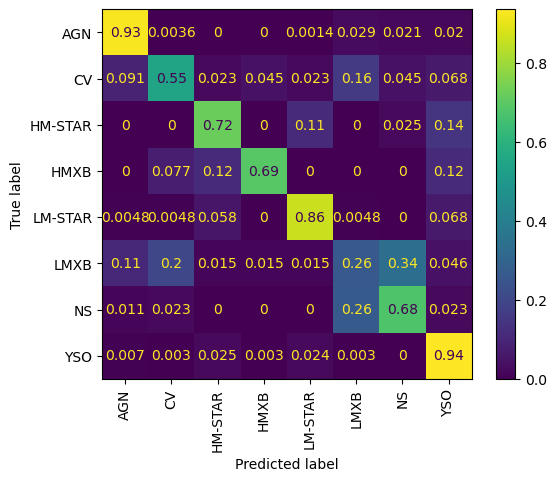

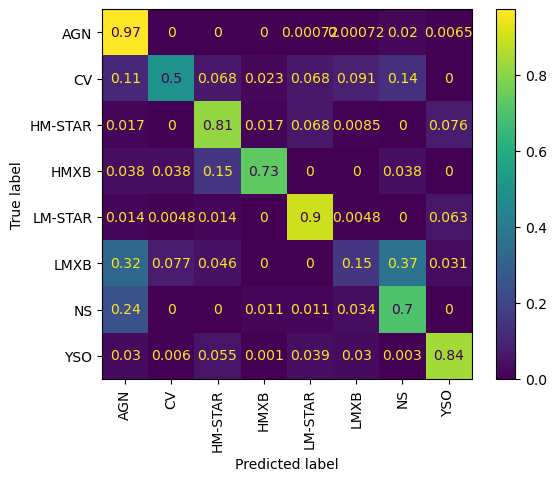

In [116]:
ConfusionMatrixDisplay.from_predictions(
    np.where(y_true==1)[1], 
    np.where(y_pred_hui==1)[1], 
    normalize='true', 
    display_labels=classes,
    xticks_rotation='vertical'
)

ConfusionMatrixDisplay.from_predictions(
    np.where(y_true==1)[1], 
    np.where(out_bin==1)[1], 
    normalize='true', 
    display_labels=classes,
    xticks_rotation='vertical'
)